<a href="https://colab.research.google.com/github/amornvitz/HCIA-AI/blob/main/Boston_House_Price_Forcast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Boston House Price Forecast**
## Objectives
*   Upon completion of this task, you will be able to: use the Boston house price data set that is open to the internet as the model input data.
*   Build, train, and evaluate machine learning models.
*   Understand the overall process of building a machine learning model.
*   Master the application of machine learning model training, grid search, and evaluation indicators.
*   master the application of related APIs.

## Datasets and Frameworks used for the experiment
*   This case is on the Boston dataset, which contains 13 features and 506 data records. Each data record contains detailed information about the house and its surroundings. Specifically, it includes urban crime rate, nitric oxide concentration, average rooms in a house, weighted distance to the downtown area and average house price. The details are as follows:
    * CRIM: urban per capita crime rate
    * ZN: proportion of residential land exceeds 25,000 square feet
    * INDUS: proportion of non-retail commercial land in a town
    * CHAS: Charles river empty variable (1 indicates that the boundary is a rivers; otherwise, the value if 0)
    * NOX: Nitric oxide concentration
    * RM: average number of rooms in a house.
    * AGE: proportion of private houses completed before 1940
    * DIS: weighted distance to the five central regions of Boston
    * RAD: proximity index of a radial highway
    * TAX: full value property tax rate of $10,000. 

    * PTRATIO: proportion of teachers and students in urban areas
    * target: average price of private houses, unit: $1,000

*   Framework: Sklearn, which provides Boston house price data, data set segmentation, standardization, and evauation functions, and integrates various common machine learning algorithms. In addition, XGboost is used, which is an optimized version of GBDT in the integration algorithm.




In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

from sklearn.datasets import load_boston

from sklearn.linear_model import RidgeCV, LassoCV, LinearRegression, ElasticNet
from sklearn.svm import  SVR

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

In [4]:
boston = load_boston()

In [10]:
boston['feature_names']

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

In [11]:
x = boston.data
y = boston.target

In [14]:
print('Feature column name')
print(boston.feature_names)
print("Sample data volume: %d, number of features: %d" % x.shape)
print("Target sample data volume: %d" % y.shape[0])

Feature column name
['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']
Sample data volume: 506, number of features: 13
Target sample data volume: 506


In [17]:
# Convert to the dataframe format.
x = pd.DataFrame(boston.data, columns = boston.feature_names)
x.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


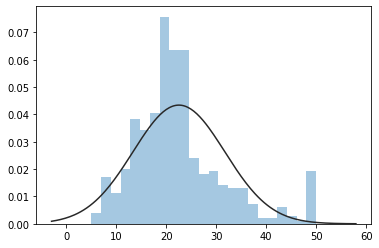

In [18]:
# Visualize label distribution
sns.distplot(tuple(y), kde=False, fit=st.norm)

In [19]:
# Split test and train dataset
# Segment the data.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 28)
# Standardize the dataset.
ss = StandardScaler()
x_train = ss.fit_transform(x_train)
x_test = ss.transform(x_test)
x_train[0:100]

array([[-0.35703125, -0.49503678, -0.15692398, ..., -0.01188637,
         0.42050162, -0.29153411],
       [-0.39135992, -0.49503678, -0.02431196, ...,  0.35398749,
         0.37314392, -0.97290358],
       [ 0.5001037 , -0.49503678,  1.03804143, ...,  0.81132983,
         0.4391143 ,  1.18523567],
       ...,
       [-0.34697089, -0.49503678, -0.15692398, ..., -0.01188637,
         0.4391143 , -1.11086682],
       [-0.39762221,  2.80452783, -0.87827504, ...,  0.35398749,
         0.4391143 , -1.28120919],
       [-0.38331362,  0.41234349, -0.74566303, ...,  0.30825326,
         0.19472652, -0.40978832]])

In [21]:
# Set the model name.
names = ['LinearRegression', 'Ridge', 'Lasso', 'Random Forest', 'GBDT', 'Support Vector Regression', 'ElasticNet', 'XgBoost']

# Define the model
models = [LinearRegression(),
          RidgeCV(alphas=(0.001,0.1,1), cv=3),
          LassoCV(alphas=(0.001, 0.1, 1), cv=5),
          RandomForestRegressor(n_estimators=10),
          GradientBoostingRegressor(n_estimators=30),
          SVR(),
          ElasticNet(alpha=0.001, max_iter=1000),
          XGBRegressor()]

In [23]:
def R2(model, x_train, x_test, y_train, y_test):
    model_fitted = model.fit(x_train, y_train)
    y_pred = model_fitted.predict(x_test)
    score = r2_score(y_test, y_pred)
    return score

# Transverse all models to score.
for name, model in zip(names, models):
    score = R2(model, x_train, x_test, y_train, y_test)
    print("{}: {:.6f}, {:.4f}".format(name, score.mean(), score.std()))

LinearRegression: 0.564115, 0.0000
Ridge: 0.563673, 0.0000
Lasso: 0.564049, 0.0000
Random Forest: 0.741792, 0.0000
GBDT: 0.736433, 0.0000
Support Vector Regression: 0.517260, 0.0000
ElasticNet: 0.563992, 0.0000
[09:47:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XgBoost: 0.761123, 0.0000


In [24]:
parameters = {
    'kernel':['linear', 'rbf'],
    'C':[0.1, 0.5, 0.9, 1.5],
    'gamma': [0.001, 0.01, 0.1, 1]
}

model = GridSearchCV(SVR(), param_grid=parameters, cv=3)
model.fit(x_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 0.5, 0.9, 1.5],
                         'gamma': [0.001, 0.01, 0.1, 1],
                         'kernel': ['linear', 'rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [25]:
print("Optimal parameter list:", model.best_params_)
print("Optimal model:", model.best_estimator_)
print("Optimal R2 value:", model.best_score_)

Optimal parameter list: {'C': 1.5, 'gamma': 0.001, 'kernel': 'linear'}
Optimal model: SVR(C=1.5, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.001,
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
Optimal R2 value: 0.7431719640014408


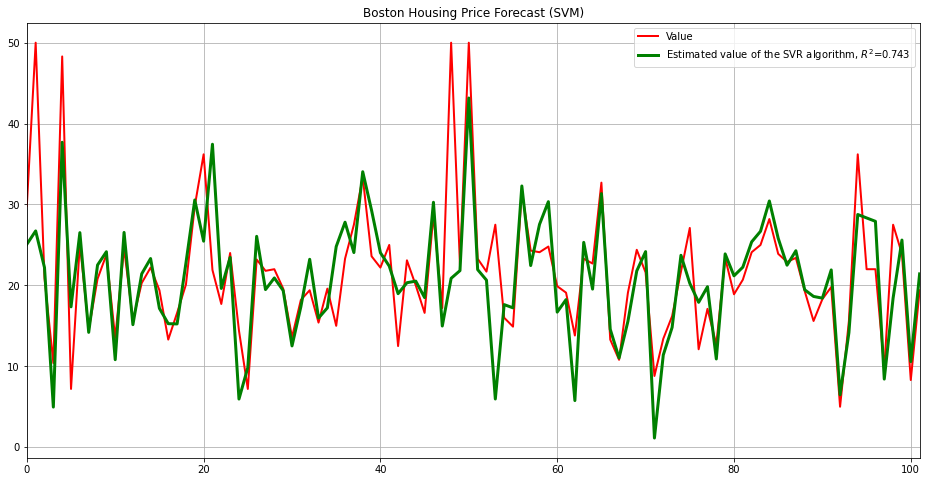

In [27]:
ln_x_test = range(len(x_test))
y_predict = model.predict(x_test)

plt.figure(figsize=(16,8), facecolor='w')
plt.plot(ln_x_test, y_test, 'r-', lw=2, label=u'Value')
# Draw with a green solid line.
plt.plot(ln_x_test, y_predict, 'g-', lw=3, label=u'Estimated value of the SVR algorithm, $R^2$=%.3f'%model.best_score_)

plt.legend(loc = 'upper right')
plt.grid(True)
plt.title(u"Boston Housing Price Forecast (SVM)")
plt.xlim(0, 101)
plt.show()